In [1]:
import pydicom

In [2]:

dcm_file = pydicom.dcmread('/Users/aditigoel/Downloads/54879843/DICOM/Doe^Pierre [54879843]/20060101 000000 [ - CRANE POLYGONE]/Series 001 [CT - Scout Profil]/image1.dcm')

In [3]:
print(dcm_file.PatientName)

Doe^Pierre


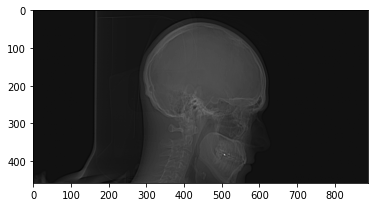

In [4]:
#to display the DICOM image using a grayscale colormap.
import matplotlib.pyplot as plt
plt.imshow(dcm_file.pixel_array, cmap=plt.cm.gray)

In [5]:
#full DICOM dataset
print(dcm_file)


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 216
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.5962.99.1.2786334768.1849416866.1385765836848.2.0
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.5962.99.2
(0002, 0013) Implementation Version Name         SH: 'PIXELMEDJAVA001'
(0002, 0016) Source Application Entity Title     AE: 'CLEANER'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'LOCALIZER']
(0008, 0012) Instance Creation Date              DA: '20060101'
(0008, 0013) Instance Creation Time              TM: '000023.000'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SO

In [6]:
print(dcm_file.Modality)

CT


In [7]:
from PIL import Image

In [8]:
pixel_array = dcm_file.pixel_array

In [9]:
# Normalize the pixel values using the rescale slope and intercept
rescale_slope = dcm_file.RescaleSlope
rescale_intercept = dcm_file.RescaleIntercept
pixel_array = pixel_array * rescale_slope + rescale_intercept

In [10]:
import numpy as np

In [11]:
# Normalize the pixel values to 0-255 range
pixel_array = (pixel_array - np.min(pixel_array)) / (np.max(pixel_array) - np.min(pixel_array)) * 255

In [12]:
# Match the image orientation and pixel spacing to a standard image
image_position_patient = dcm_file.ImagePositionPatient
image_orientation_patient = dcm_file.ImageOrientationPatient
pixel_spacing = dcm_file.PixelSpacing
row_cosine = np.array(image_orientation_patient[0:3])
column_cosine = np.array(image_orientation_patient[3:6])
image_center = np.array(image_position_patient)
row_spacing, column_spacing = pixel_spacing
x_spacing = np.linalg.norm(row_spacing * row_cosine)
y_spacing = np.linalg.norm(column_spacing * column_cosine)
z_spacing = np.linalg.norm(pixel_spacing)
x_direction = row_cosine * x_spacing
y_direction = column_cosine * y_spacing
z_direction = np.cross(x_direction, y_direction)
transformation_matrix = np.array([x_direction.tolist() + [0],
                                  y_direction.tolist() + [0],
                                  z_direction.tolist() + [0],
                                  image_center.tolist() + [1]])
transformation_matrix_inv = np.linalg.inv(transformation_matrix)
output_pixel_array = np.zeros((512, 512)) # Replace with desired output shape
for i, j in np.ndindex(output_pixel_array.shape):
    pixel_coordinates = np.array([i, j, 0, 1])
    new_coordinates = transformation_matrix_inv.dot(pixel_coordinates)
    x, y, z, _ = new_coordinates
    x_index = int(round(x / x_spacing))
    y_index = int(round(y / y_spacing))
    if x_index < 0 or x_index >= pixel_array.shape[0] or y_index < 0 or y_index >= pixel_array.shape[1]:
        continue
    output_pixel_array[i, j] = pixel_array[x_index, y_index]


In [13]:
# Convert the pixel array to a PIL Image
img = Image.fromarray(pixel_array.astype('uint8'))

In [14]:
img.save('/Users/aditigoel/Desktop/dip out put image/output.png')

Check Whether Image Enhancement is required or not

In [15]:
import cv2

In [16]:
# Load the converted image
img = cv2.imread('/Users/aditigoel/Desktop/dip out put image/output.png')

In [18]:
# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [19]:
# Perform histogram equalization
equalized = cv2.equalizeHist(gray)

In [28]:
def calculate_contrast_brightness(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    mean_intensity = np.mean(gray)
    std_intensity = np.std(gray)
    contrast = std_intensity / mean_intensity
    brightness = np.mean(img)
    return contrast, brightness

In [29]:
def is_enhancement_required(contrast, brightness):
    if contrast < 0.05 or brightness > 200:
        return True
    else:
        return False

In [32]:
# Calculate contrast and brightness
contrast, brightness = calculate_contrast_brightness(img)
print("Contrast: {:.2f}".format(contrast))
print("Brightness: {:.2f}".format(brightness))

# Determine if enhancement is required
if is_enhancement_required(contrast, brightness):
    print("Image enhancement is required")
else:
    print("Image enhancement is not required")



Contrast: 0.43
Brightness: 144.42
Image enhancement is not required


In [33]:
# Save the equalized image
equalized_img = Image.fromarray(equalized)
equalized_img.save('/Users/aditigoel/Desktop/dip out put image/equalized img.png')

Applying Image Enhancement 

Gamma Correction:

In [34]:
# Load the equalized image
img = cv2.imread('/Users/aditigoel/Desktop/dip out put image/equalized img.png')

In [35]:
# Define the gamma value
gamma = 1.5

In [36]:
# Apply gamma correction
gamma_corrected = np.power(img / 255.0, gamma)
gamma_corrected = np.uint8(gamma_corrected * 255)

In [37]:
# Compute the contrast and brightness of the gamma-corrected image
mean3 = np.mean(gamma_corrected)
std3 = np.std(gamma_corrected)
contrast2 = std3 / std2
brightness2 = mean3 - mean2

In [38]:
# Print the contrast and brightness values
print(f'Contrast: {contrast2:.2f}')
print(f'Brightness: {brightness2:.2f}')

Contrast: 1.10
Brightness: -28.58


In [39]:
# Save the gamma-corrected image
gamma_corrected_img = Image.fromarray(gamma_corrected)
gamma_corrected_img.save('/Users/aditigoel/Desktop/dip out put image/gamma15.png')

Local Contrast Enhancement:

In [40]:
# Load the equalized image
img = cv2.imread('/Users/aditigoel/Desktop/dip out put image/gamma15.png')

In [41]:
# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [42]:
# Apply local contrast enhancement
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_img = clahe.apply(gray)


In [43]:
# Compute the contrast and brightness of the CLAHE-enhanced image
mean4 = np.mean(clahe_img)
std4 = np.std(clahe_img)
contrast3 = std4 / std2
brightness3 = mean4 - mean2

In [44]:
# Print the contrast and brightness values
print(f'Contrast: {contrast3:.2f}')
print(f'Brightness: {brightness3:.2f}')

Contrast: 1.05
Brightness: -32.92


In [45]:
# Save the CLAHE-enhanced image
clahe_img = Image.fromarray(clahe_img)
clahe_img.save('/Users/aditigoel/Desktop/dip out put image/claheimg.png')

Applied local contrast enhancement using the Contrast Limited Adaptive Histogram Equalization (CLAHE) algorithm with a clip limit of 2.0 and a tile size of 8x8. 

In [46]:
# Load the enhanced image
enhanced_img = Image.open('/Users/aditigoel/Desktop/dip out put image/claheimg.png')

In [47]:
# Convert the image to a numpy array
enhanced_array = np.array(enhanced_img)

In [48]:
# Create a DICOM file with appropriate header information
ds = pydicom.dcmread('/Users/aditigoel/Downloads/54879843/DICOM/Doe^Pierre [54879843]/20060101 000000 [ - CRANE POLYGONE]/Series 001 [CT - Scout Profil]/image1.dcm')

In [49]:
# Set the pixel data to the enhanced image data
ds.PixelData = enhanced_array.tobytes()

In [50]:
# Set the image dimensions and other header fields
ds.Rows, ds.Columns = enhanced_array.shape

In [51]:
ds.BitsAllocated = 8
ds.BitsStored = 8
ds.HighBit = 7
ds.PixelRepresentation = 0
ds.SamplesPerPixel = 1
ds.PhotometricInterpretation = "MONOCHROME2"
ds.Modality = "CT"
ds.PatientID = "12345"
ds.SeriesInstanceUID = "1.2.3.4.5"
ds.StudyInstanceUID = "1.2.3.4.5.6"
ds.ImagePositionPatient = [0, 0, 0]
ds.ImageOrientationPatient = [1, 0, 0, 0, 1, 0]
ds.SliceThickness = 1.0
ds.PixelSpacing = [1.0, 1.0]


In [54]:
# Save the DICOM file
pydicom.dcmwrite('/Users/aditigoel/Desktop/dip out put image/enhanced_dicom.dcm', ds)